## Data Science Summer School - Split '17

## 5. Generating images of digits with Generative Adversarial Networks

This hands-on session is based on ...

The datasets used in this sessions will be MNIST, a staple dataset ... and CelebA, ...

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import util
import glob
import time

In [2]:
# mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

## 5.1 Downloading the datasets and previewing data

In [3]:
data_dir = 'assets'
util.download_extract('mnist', data_dir)
util.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


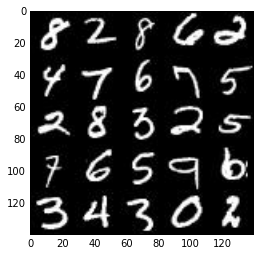

In [4]:
show_n_images = 25
mnist_sample = util.get_sample_images(data_dir, dataset='mnist', n=show_n_images)
plt.imshow(mnist_sample, cmap='gray')

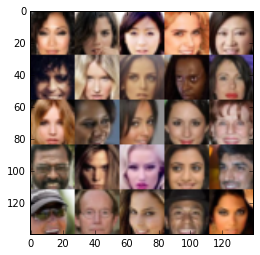

In [5]:
celebA_sample = util.get_sample_images(data_dir, dataset='celebA', n=show_n_images)
plt.imshow(celebA_sample)

[[   0.,   0.,   1.,   2.,   6.,   0.,  12.,   4.,   4.,   0.,   0.,   1.,  15.,   0.,   4.,   0.],
 [   0.,   0.,   0.,   2.,   0.,   2.,   3.,   0.,   0.,   4.,   6.,   0.,   0.,   0.,   6.,   0.],
 [   0.,   0.,   0.,   3.,   0.,   5.,   6.,   0.,  10.,  10.,   0.,  17.,   3.,   2.,   0.,   3.],
 [   0.,   0.,   0.,   5.,   0.,   1.,  13.,   1.,  14.,   0.,   8.,   0.,   0.,   1.,   7.,   0.],
 [   0.,   0.,   0.,   1.,  13.,   1.,   2.,   0.,  17.,   0.,   3.,   0.,  11.,  11.,   0.,   6.],
 [   0.,   0.,   1.,   0.,  16.,   0.,   0.,  13., 105., 159., 247., 255., 230., 135.,   0.,  11.],
 [   0.,   0.,   3.,   0.,   3.,   0.,   5., 138., 221., 255., 240., 255., 255., 248.,  98.,   0.],
 [   0.,   0.,   0.,   0.,   0.,   5.,  41., 253., 255., 246., 255., 245., 242., 255., 213.,  80.],
 [   0.,   0.,   0.,  10.,   0.,  18., 165., 255., 255., 239., 202., 210., 185., 247., 251., 255.],
 [   0.,   0.,  11.,   0.,   0.,   3., 248., 255., 187.,  67.,   2.,   0., 133., 255., 251., 252.],


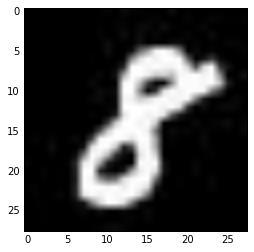

In [6]:
sample = util.get_single_image(data_dir, dataset='mnist')
sample = sample.reshape((28, 28))
sample.shape
print(np.array2string(sample[:, 6:-6], max_line_width=100, separator=',', precision=0))
plt.imshow(sample, cmap='gray')

## 3.3 The basic network for the discriminator

In [7]:
class Discriminator:
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        # we define a two-layer ANN as the discriminator
        
        with tf.variable_scope("discriminator"):
            # Discriminator
            # input -> hidden
            self.W1 = tf.get_variable(name="W1", shape=[input_dim, hidden_dim], 
                                      initializer=tf.contrib.layers.xavier_initializer())
            self.b1 = tf.get_variable(name="b1", shape=[hidden_dim], 
                                      initializer=tf.zeros_initializer())
            
            # hidden -> prediction
            self.W2 = tf.get_variable(name="W2", shape=[hidden_dim, output_dim], 
                                      initializer=tf.contrib.layers.xavier_initializer())
            self.b2 = tf.get_variable(name="b2", shape=[output_dim], 
                                      initializer=tf.zeros_initializer())

            self.theta = [self.W1, self.W2, self.b1, self.b2]
    
    def forward(self, x):
        h1 = tf.nn.relu(tf.matmul(x, self.W1) + self.b1)
        logit = tf.matmul(h1, self.W2) + self.b2
        prob = tf.nn.sigmoid(logit)

        return prob, logit

    
    def params(self):
        return self.theta


## 3.4 The basic network for the generator

In [8]:
class Generator:
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        # we define a two-layer ANN as the generator
        
        with tf.variable_scope("generator"):
            # Generator
            # input -> hidden
            self.W1 = tf.get_variable(name="W1", shape=[input_dim, hidden_dim], 
                                      initializer=tf.contrib.layers.xavier_initializer())
            self.b1 = tf.get_variable(name="b1", shape=[hidden_dim], 
                                      initializer=tf.zeros_initializer())
            
            # hidden -> prediction
            self.W2 = tf.get_variable(name="W2", shape=[hidden_dim, output_dim], 
                                      initializer=tf.contrib.layers.xavier_initializer())
            self.b2 = tf.get_variable(name="b2", shape=[output_dim], 
                                      initializer=tf.zeros_initializer())

            self.theta = [self.W1, self.W2, self.b1, self.b2]
    
    def forward(self, z):
        h1 = tf.nn.relu(tf.matmul(z, self.W1) + self.b1)
        log_prob = tf.matmul(h1, self.W2) + self.b2
        prob = tf.nn.sigmoid(log_prob)

        return prob

    def params(self):
        return self.theta


### Helper methods

In [9]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])    

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

def plot_single(sample):
    plt.axis('off')
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

## 3.5 Define the model loss

In [10]:
def model_loss(X, Z, discriminator, generator):
    # D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
    # G_loss = -tf.reduce_mean(tf.log(D_fake))

    # Alternative losses:
    # -------------------

    G_sample = g.forward(Z)
    D_real, D_logit_real = d.forward(X)
    D_fake, D_logit_fake = d.forward(G_sample)

    D_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                            logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
    D_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))

    D_loss = D_loss_real + D_loss_fake

    G_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

    return G_sample, D_loss, G_loss
    

In [11]:
dataset = util.Dataset('mnist', glob.glob(os.path.join(data_dir, 'mnist/*.jpg')))
new_epoch, X_mb = dataset.next_batch(128)
X_mb.reshape(128, -1).shape

(128, 784)

In [12]:
image_dim = 784
hidden_dim = 128
output_dim = 1
sample_dim = 100
mb_size = 128

num_iter = 100000
plot_every = 1000
print_every = 1000

In [13]:
d = Discriminator(image_dim, hidden_dim, output_dim)
for param in d.params():
    print (param.name)
    
g = Generator(sample_dim, hidden_dim, image_dim)
for param in g.params():
    print (param.name)

discriminator/W1:0
discriminator/W2:0
discriminator/b1:0
discriminator/b2:0
generator/W1:0
generator/W2:0
generator/b1:0
generator/b2:0


In [14]:
X = tf.placeholder(tf.float32, name="input", shape=[None, image_dim])
Z = tf.placeholder(tf.float32, name="latent_sample", shape=[None, sample_dim])

G_sample, D_loss, G_loss = model_loss(X, Z, d, g)

with tf.variable_scope('optim'):
    D_solver = tf.train.AdamOptimizer(name='discriminator').minimize(D_loss, var_list=d.params())
    G_solver = tf.train.AdamOptimizer(name='generator').minimize(G_loss, var_list=g.params())


In [15]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

saver = tf.train.Saver()

n_samples = mnist.train.num_examples
epochs = 10

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


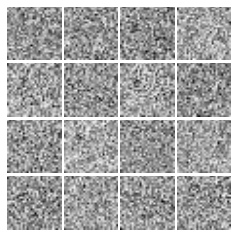

Epoch: 0/10
Iter: 128/55000
Discriminator loss: 1.352
Generator loss: 2.617



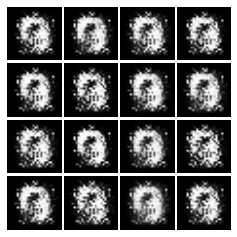

Epoch: 2/10
Iter: 18128/55000
Discriminator loss: 0.02673
Generator loss: 6.504



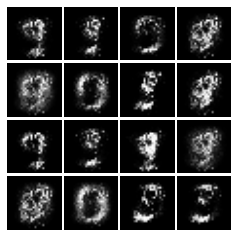

Epoch: 4/10
Iter: 36128/55000
Discriminator loss: 0.1014
Generator loss: 4.062



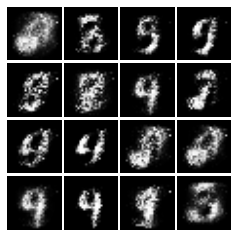

Epoch: 6/10
Iter: 54128/55000
Discriminator loss: 0.09602
Generator loss: 4.583



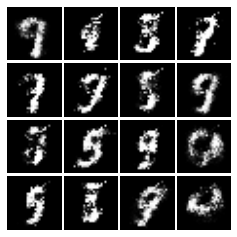

Epoch: 9/10
Iter: 17128/55000
Discriminator loss: 0.1733
Generator loss: 5.161



In [16]:
it = 0
with tf.device("/gpu:0"), tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    if not os.path.exists('out/'):
        os.makedirs('out/')
    
    while mnist.train.epochs_completed < epochs:
        if it % plot_every == 0:
            samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, sample_dim)})

            fig = plot(samples)
            plt.savefig('out/{}.png'.format(str(it).zfill(3)), bbox_inches='tight')
            #plt.plot(fig)
            plt.show()
            plt.close(fig)

        #new_epoch, X_mb = dataset.next_batch(mb_size)
        #X_mb = X_mb.reshape(mb_size, -1)
        
        X_mb, _ = mnist.train.next_batch(mb_size)
        
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, sample_dim)})
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, sample_dim)})

        if it % print_every == 0:
            print('Epoch: {}/{}'.format(mnist.train.epochs_completed, epochs))
            print('Iter: {}/{}'.format(mnist.train._index_in_epoch, n_samples))
            print('Discriminator loss: {:.4}'. format(D_loss_curr))
            print('Generator loss: {:.4}'.format(G_loss_curr))
            print()
        it += 1
    
    saver.save(sess, "assets/checkpoints/mnist/fc_2layer_e{}_{:.3f}.ckpt".format(
        mnist.train.epochs_completed, G_loss_curr))

In [16]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def manual_sample(zz, loc, z, sess):

        z[0,loc] = zz
        print(z)
        sample = sess.run(G_sample, feed_dict={Z: z})
        plot_single(sample)
        plt.show()

sess = tf.Session()
tf.device("/gpu:0")
#with tf.device("/gpu:0"), tf.Session() as sess:
sess.run(tf.global_variables_initializer())
saver.restore(sess, 'assets/checkpoints/mnist/fc_2layer_e10_5.913.ckpt')

z = sample_Z(1, sample_dim)
interact(manual_sample, 
             zz=widgets.FloatSlider(min=0,max=1,value=0.001), 
             loc=widgets.IntSlider(min=0,max=99, value=1),
             sess=fixed(sess), z=fixed(z),
            height=300, margin=300)


INFO:tensorflow:Restoring parameters from assets/checkpoints/mnist/fc_2layer_e10_5.913.ckpt


<function __main__.manual_sample>